<a href="https://colab.research.google.com/github/wlghksx/Tensorflow_Tutorial/blob/main/Tensorflow_Tutorial_%EA%B8%B0%EB%B3%B8_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 리뷰를 사용한 텍스트 분류

이 노트북은 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 이진(binary)-또는 클래스(class)가 두 개인- 분류 문제입니다. 이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.

여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용하겠습니다. 25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있습니다. 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.5.0


## IMDB 데이터셋 다운로드

IMDB 데이터셋은 텐서플로와 함께 제공됩니다. **리뷰(단어의 시퀀스(sequence))는 미리 전처리해서 정수 시퀀스로 변환되어 있습니다. 각 정수는 어휘 사전에 있는 특정 단어를 의미합니다.**

**다음 코드는 IMDB 데이터셋을 컴퓨터에 다운로드합니다(또는 이전에 다운로드 받았다면 캐시된 복사본을 사용합니다):**

In [3]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = \
imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

매개변수 num_words=10000은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어를 선택합니다. 데이터 크기를 적당하게 유지하기 위해 드물에 등장하는 단어는 제외하겠습니다.

## 데이터 탐색

잠시 데이터 형태를 알아 보겠습니다. 이 데이터셋의 샘플은 전처리된 정수 배열입니다. 이 정수는 영화 리뷰에 나오는 단어를 나타냅니다. 레이블(label)은 정수 0 또는 1입니다. 0은 부정적인 리뷰이고 1은 긍정적인 리뷰입니다.

In [4]:
print("훈련 샘플 : {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플 : 25000, 레이블: 25000


리뷰 텍스트는 어휘 사전의 특정 단어 수를 나타내는 정수로 변환되어 있다.

첫번째 리뷰를 확인 해보자.

In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


영화 리뷰들은 길이가 다들 다르다.

다음 코드는 첫 번째 리뷰와 두 번째 리뷰의 단어의 개수를 출력한다. 

신경망의 입력은 길이가 같아야 하기 때문에 나중에 이 문제를 해결해야 한다.

In [6]:
len(train_data[0]), len(train_data[1])

(218, 189)

## 정수를 단어로 다시 변환하기

정수를 다시 텍스트로 변환하는 방법이 있다면 유용할 것입니다. 

여기에서는 정수와 문자열을 매핑한 딕셔너리(dictionary) 객체에 질의하는 헬퍼(helper) 함수를 만들겠습니다:

In [7]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있다.
word_index = {k:(v+3) for k,v in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 #unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_review(text):
  return ' '.join([reverse_word_index.get(i,'?') for i in text])




1646592/1641221 [==============================] - 0s 0us/step


우선 reverse_word_index를 사용하여 단어와 index의 딕셔너리를 반대로 뒤집는 과정을 수행하는 변수를 지정한다

그리고 decode_review(text) 함수를 이용하여 인덱스를 받아 그 인덱스에 맞는 저장되어 있는 단어를 반환하는 과정을 각 리뷰 데이터에 적용시킬 수 있게 된다.

이제 decode_review 함수를 사용해 첫 번째 리뷰 텍스트를 출력할 수 있다.

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# 데이터 준비

리뷰 - 정수 배열은 신경망에 주입하기 전에 텐서로 변환되어야 한다.

변환하는 방법에는 몇 가지가 있는데,

1. 원 - 핫 인코딩은 정수 배열을 0,1로 이루어진 벡터로 변환. 

예를 들면, [3,5]를 3과 5만 1이고 나머지는 0인 10,000차원 벡터로 변환할 수 있다. 그 다음 실수 벡터 데이터를 다룰 수 있는 층-Dense층 을 신경망의 첫 번째 층으로 사용한다. 

이 방법은 num words * num_reviews 크기의 행렬이 필요하기 때문에 메모리를 많이 사용한다.

2. 다른 방법으로는, 정수 배열의 길이기 모두 같도록 패딩을 추가해 max_length * num_reviews 크기의 정수 텐서를 만든다. 이런 형태의 텐서를 다룰 수 있는 임베딩 층을 신경망의 첫 번째 층으로 사용할 수 있다.

지금 튜토리얼에서는 두 번째 방식을 사용하도록 하겠다.

영화 리뷰의 길이가 같아야 하므로 pad_sequences 함수를 사용해 길이를 맞추겠습니다.

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding = 'post',
                                                        maxlen = 256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen = 256)

이 함수를 통해 총 길이가 256이 되도록 단어를 padding 시켜주었다.

샘플의 길이를 확인.

In [15]:
len(train_data[0]), len(train_data[1])

(256, 256)

(패딩된)첫 번째 리뷰 내용을 확인해 보겠습니다.

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

# 모델 구성

신경망은 층(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

- 모델에서 얼마나 많은 층을 사용할 것인가?
- 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성해 보겠습니다:

In [16]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다.(10,000개의 단어)

vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


층을 순서대로 쌓아 분류기(classifier)를 만든다.

1. 첫 번째 층은 Embedding 층이다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾는다. 이 벡터는 모델이 훈련되면서 학습된다. 이 벡터는 출력 배열에 새로운 차원으로 추가된다. 최종 차원은 (batch,sequence,embedding) 이 된다.

2. 그 다음 GlobalAveragePooling1d 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환한다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법이다.

3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결 층을 거친다.

4. 마지막 층은 하나의 출력 노드를 가진 완전 연결 층이다. sigmoid 활성화 함수를 사용하여 0,1 사이의 실수를 출력한다. 이 값은 확률 또는 신뢰도를 나타낸다.

## 은닉 유닛
위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 층이 있습니다. 출력(유닛 또는 노드, 뉴런)의 개수는 층이 가진 표현 공간(representational space)의 차원이 됩니다. 다른 말로 하면, 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양입니다.

모델에 많은 은닉 유닛(고차원의 표현 공간)과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 그렇지 못합니다. 이를 과대적합(overfitting)이라고 부릅니다. 나중에 이에 대해 알아 보겠습니다.

## 손실 함수와 옵티마이저
모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 sigmoid 활성화 함수를 사용합니다), binary_crossentropy 손실 함수를 사용하겠습니다.

다른 손실 함수를 선택할 수 없는 것은 아닙니다. 예를 들어 mean_squared_error를 선택할 수 있습니다. 하지만 일반적으로 binary_crossentropy가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

나중에 회귀(regression) 문제(예를 들어 주택 가격을 예측하는 문제)에 대해 살펴 볼 때 평균 제곱 오차(mean squared error) 손실 함수를 어떻게 사용하는지 알아 보겠습니다.

이제 모델이 사용할 옵티마이저와 손실 함수를 설정해 보겠습니다:

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 검증 세트 만들기
모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋습니다. 원본 훈련 데이터에서 10,000개의 샘플을 떼어내어 검증 세트(validation set)를 만들겠습니다. (왜 테스트 세트를 사용하지 않을까요? 훈련 데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표입니다. 그다음 테스트 세트를 사용해서 딱 한 번만 정확도를 평가합니다).

In [18]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 모델 훈련
이 모델을 512개의 샘플로 이루어진 미니배치(mini-batch)에서 40번의 에포크(epoch) 동안 훈련합니다. x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻입니다. 훈련하는 동안 10,000개의 검증 세트에서 모델의 손실과 정확도를 모니터링합니다:

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 24ms/step - loss: 0.6924 - accuracy: 0.5075 - val_loss: 0.6909 - val_accuracy: 0.5430
Epoch 2/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6864 - accuracy: 0.6152 - val_loss: 0.6817 - val_accuracy: 0.6212
Epoch 3/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6719 - accuracy: 0.7163 - val_loss: 0.6639 - val_accuracy: 0.7054
Epoch 4/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6468 - accuracy: 0.7556 - val_loss: 0.6355 - val_accuracy: 0.7573
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6103 - accuracy: 0.7883 - val_loss: 0.5975 - val_accuracy: 0.7916
Epoch 6/40
30/30 [==============================] - 1s 18ms/step - loss: 0.5656 - accuracy: 0.8123 - val_loss: 0.5549 - val_accuracy: 0.8077
Epoch 7/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5182 - accuracy: 0.8335 - val_loss: 0.5117 - val_accuracy: 0.8235
Epoch 8/40
30

## 모델 평가
모델의 성능을 확인해 보죠. 두 개의 값이 반환됩니다. 손실(오차를 나타내는 숫자이므로 낮을수록 좋습니다)과 정확도입니다.

In [20]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)


782/782 - 1s - loss: 0.3368 - accuracy: 0.8706
[0.33679428696632385, 0.8705599904060364]


이 예제는 매우 단순한 방식을 사용하므로 87% 정도의 정확도를 달성했습니다. 고급 방법을 사용한 모델은 95%에 가까운 정확도를 얻습니다.

# 정확도와 손실 그래프 그리기
model.fit()은 History 객체를 반환합니다. 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리(dictionary)가 들어 있습니다:



In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

네 개의 항목이 있습니다. 훈련과 검증 단계에서 모니터링하는 지표들입니다. 훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도도 그래프로 그려서 비교해 보겠습니다:

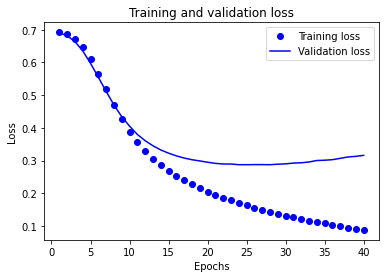

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

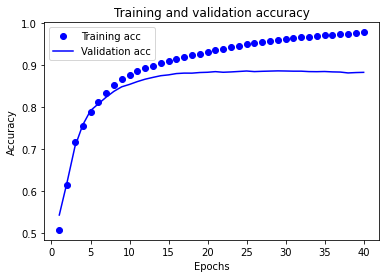

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다.

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다는 것을 주목하세요. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다.

하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 약 20번째 에포크 이후가 최적점인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되기 어려운 훈련 데이터의 특정 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있습니다. 나중에 콜백(callback)을 사용하여 자동으로 이렇게 하는 방법을 배워 보겠습니다.